In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv
/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv


In [2]:
train_df=pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/train.csv')
test_df=pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/test.csv')
sample_df=pd.read_csv('/kaggle/input/recipe-for-rating-predict-food-ratings-using-ml/sample.csv')

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest, chi2
from lightgbm import LGBMClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, classification_report
from itertools import cycle
from datetime import datetime
from scipy.sparse import hstack



# Preliminary Data Exploration


In [4]:
print(train_df.shape)
print(test_df.shape)

(13636, 15)
(4546, 14)


In [5]:
train_df.head()


,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,Rating,BestScore,Recipe_Review
0,70,71,12259,Banana Bars with Cream Cheese Frosting,sp_aUSaElGf_12259_c_149978,u_1oKVaBmiEKwAFyiHrDLoWpbel0J,misscoffeepot,20,1622717078,0,0,0,5,100,great recipe! I have made them just as written...
1,72,88,8202,Simple Taco Soup,sp_aUSaElGf_8202_c_310332,u_1oKZeRIXYzGNhGW8OMR3O4lX1ih,MichelleMalone,1,1622717852,0,0,1,5,100,This is an easy and quick recipe that is great...
2,458,3,2832,Cheeseburger Soup,sp_aUSaElGf_2832_c_206522,u_1oKYHUtdaD48KJCDYq5wfpAUxWz,jeannem32,1,1622717357,0,0,0,3,100,I think I was looking for something extra spec...
3,7,50,100276,Grilled Huli Huli Chicken,sp_aUSaElGf_100276_c_434088,u_1oKZCQcKQZdQhDVBS7oISc216VA,ds422,1,1622648899,0,0,0,5,100,This is our favorite grilled chicken recipe. ...
4,60,12,19731,Cauliflower Soup,sp_aUSaElGf_19731_c_387011,u_1oKd4sudZQPgu6YALiC7bW7mKMs,SusanHoward,1,1622718260,0,0,0,4,100,Great basic recipe. I added 2 teaspoons Tuscan...


In [6]:
test_df.head()

,ID,RecipeNumber,RecipeCode,RecipeName,CommentID,UserID,UserName,UserReputation,CreationTimestamp,ReplyCount,ThumbsUpCount,ThumbsDownCount,BestScore,Recipe_Review
0,86,45,41384,Black Bean ‘n’ Pumpkin Chili,sp_aUSaElGf_41384_c_341929,u_1oKc4U6bh65cEli8Z8eTIf98Vpr,kalloween,1,1622718043,0,0,0,100,This was so good!! The pumpkin was perfect as...
1,102,53,3143,Pumpkin Bars,sp_aUSaElGf_3143_c_274545,u_1oKW5seFLQMSwAeOfBVmwJizy5D,chocolate desert,1,1622717685,0,0,1,100,"So good! Could not stop eating them, so bad...."
2,156,53,3143,Pumpkin Bars,sp_aUSaElGf_3143_c_398512,u_1oKZ6GUIAIol8xe6oEI7t1Mpxdz,Vantreesta,1,1622718307,0,0,0,100,I use a small ladle to fill muffin cups.
3,18,89,1324,Porcupine Meatballs,sp_aUSaElGf_1324_c_431662,u_1oKWCP33NVk4Osfpu4VJuIckEF0,Roberta L.Beauchamp,1,1622648872,0,4,3,212,I made this and followed the instructions as d...
4,27,70,32264,Easy Chicken Enchiladas,sp_aUSaElGf_32264_c_423935,u_1oKVhIJMuUlrSCVkbO1jheVTol8,fhquilting,1,1622718460,0,0,1,100,Very Good! I used corn tortillas. Used fresh...


In [7]:
sample_df.head()

,ID,Rating
0,1,5
1,2,2
2,3,4
3,4,2
4,5,4


In [8]:
print(train_df.dtypes)
print(test_df.dtypes)


ID                    int64
RecipeNumber          int64
RecipeCode            int64
RecipeName           object
CommentID            object
UserID               object
UserName             object
UserReputation        int64
CreationTimestamp     int64
ReplyCount            int64
ThumbsUpCount         int64
ThumbsDownCount       int64
Rating                int64
BestScore             int64
Recipe_Review        object
dtype: object
ID                    int64
RecipeNumber          int64
RecipeCode            int64
RecipeName           object
CommentID            object
UserID               object
UserName             object
UserReputation        int64
CreationTimestamp     int64
ReplyCount            int64
ThumbsUpCount         int64
ThumbsDownCount       int64
BestScore             int64
Recipe_Review        object
dtype: object


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 13636 non-null  int64 
 1   RecipeNumber       13636 non-null  int64 
 2   RecipeCode         13636 non-null  int64 
 3   RecipeName         13636 non-null  object
 4   CommentID          13636 non-null  object
 5   UserID             13636 non-null  object
 6   UserName           13636 non-null  object
 7   UserReputation     13636 non-null  int64 
 8   CreationTimestamp  13636 non-null  int64 
 9   ReplyCount         13636 non-null  int64 
 10  ThumbsUpCount      13636 non-null  int64 
 11  ThumbsDownCount    13636 non-null  int64 
 12  Rating             13636 non-null  int64 
 13  BestScore          13636 non-null  int64 
 14  Recipe_Review      13634 non-null  object
dtypes: int64(10), object(5)
memory usage: 1.6+ MB


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4546 entries, 0 to 4545
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   ID                 4546 non-null   int64 
 1   RecipeNumber       4546 non-null   int64 
 2   RecipeCode         4546 non-null   int64 
 3   RecipeName         4546 non-null   object
 4   CommentID          4546 non-null   object
 5   UserID             4546 non-null   object
 6   UserName           4546 non-null   object
 7   UserReputation     4546 non-null   int64 
 8   CreationTimestamp  4546 non-null   int64 
 9   ReplyCount         4546 non-null   int64 
 10  ThumbsUpCount      4546 non-null   int64 
 11  ThumbsDownCount    4546 non-null   int64 
 12  BestScore          4546 non-null   int64 
 13  Recipe_Review      4546 non-null   object
dtypes: int64(9), object(5)
memory usage: 497.3+ KB


In [11]:
train_df.isnull().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        2
dtype: int64

#### * Recipe_Review column has 2 missing values. We could either fill these missing values or remove them. 

In [12]:
test_df.isnull().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
BestScore            0
Recipe_Review        0
dtype: int64

#### *No missing values in the test dataset.

In [13]:
train_df.describe(include='all').T


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,13636.0,NaN,NaN,NaN,121.085289,116.995633,0.0,45.0,91.0,148.0,724.0
RecipeNumber,13636.0,NaN,NaN,NaN,38.624377,29.672351,1.0,12.0,33.0,63.0,100.0
RecipeCode,13636.0,NaN,NaN,NaN,21785.990833,23883.189918,386.0,6504.0,14600.0,33121.0,191775.0
RecipeName,13636,100,Cheeseburger Soup,553,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CommentID,13636,13636,sp_aUSaElGf_12259_c_149978,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UserID,13636,10783,u_1oKVZoIOMWJ2j7TA7py2BIbf1mm,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UserName,13636,10620,mjlouk,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UserReputation,13636.0,NaN,NaN,NaN,2.160311,10.086424,0.0,1.0,1.0,1.0,510.0
CreationTimestamp,13636.0,NaN,NaN,NaN,1623713409.344603,5444020.160422,1613035336.0,1622717242.0,1622717707.0,1622718172.0,1665756035.0
ReplyCount,13636.0,NaN,NaN,NaN,0.01452,0.137323,0.0,0.0,0.0,0.0,3.0


In [14]:
test_df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,4546.0,NaN,NaN,NaN,122.605147,116.006955,0.0,46.0,92.0,154.0,715.0
RecipeNumber,4546.0,NaN,NaN,NaN,38.884294,30.129333,1.0,11.0,32.0,64.0,100.0
RecipeCode,4546.0,NaN,NaN,NaN,21736.701936,24211.777711,386.0,6086.0,14600.0,33121.0,191775.0
RecipeName,4546,100,Cheeseburger Soup,172,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CommentID,4546,4546,sp_aUSaElGf_41384_c_341929,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UserID,4546,4060,u_1oKVeN9YNf07RT0P9R63Yu80P5A,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UserName,4546,4029,JGa2595176,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
UserReputation,4546.0,NaN,NaN,NaN,2.157501,9.797366,0.0,1.0,1.0,1.0,520.0
CreationTimestamp,4546.0,NaN,NaN,NaN,1623701716.386934,5542651.533505,1613035422.0,1622717233.0,1622717706.5,1622718165.0,1665668513.0
ReplyCount,4546.0,NaN,NaN,NaN,0.014958,0.139922,0.0,0.0,0.0,0.0,3.0


#### 1. Both the datasets have 100 unique recipes with Cheeseburger Soup commmon in both, suggesting it could be a popular choice.
#### 2. The distribution of UserReputation is similar in both datasets, with a majority of users having low reputation scores. 
#### 3. Interaction features such as ReplyCount, ThumbsUpCount, ThumbsDownCount show a right-skewd distribution in both the sets, indicating a low engagement across recipes or comments.
#### 4. Rating which is the target variable leans towards higher ratings.

## Visualising the top 10 recipes in both the sets

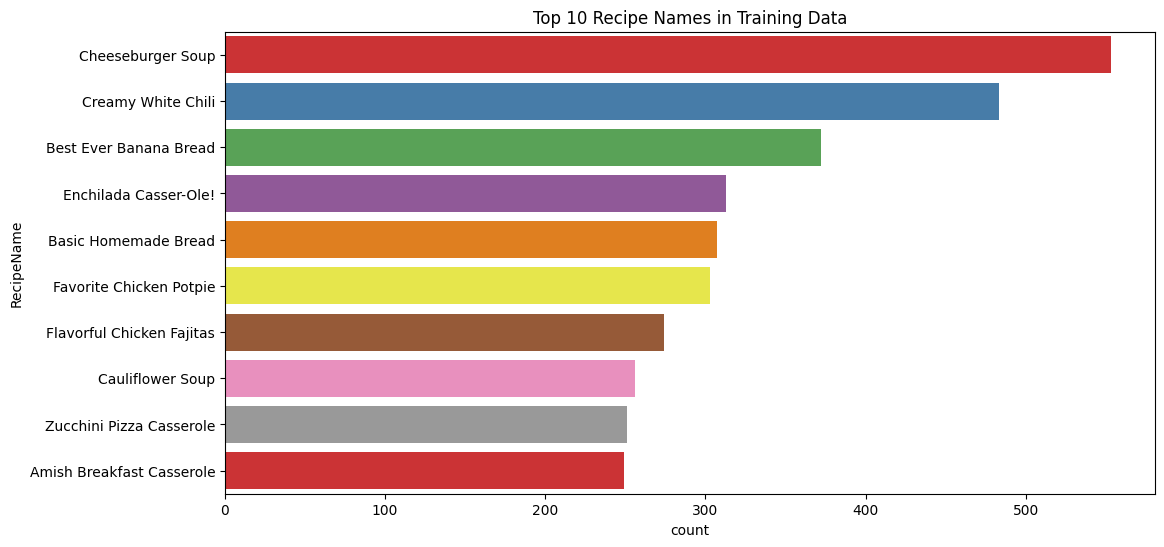

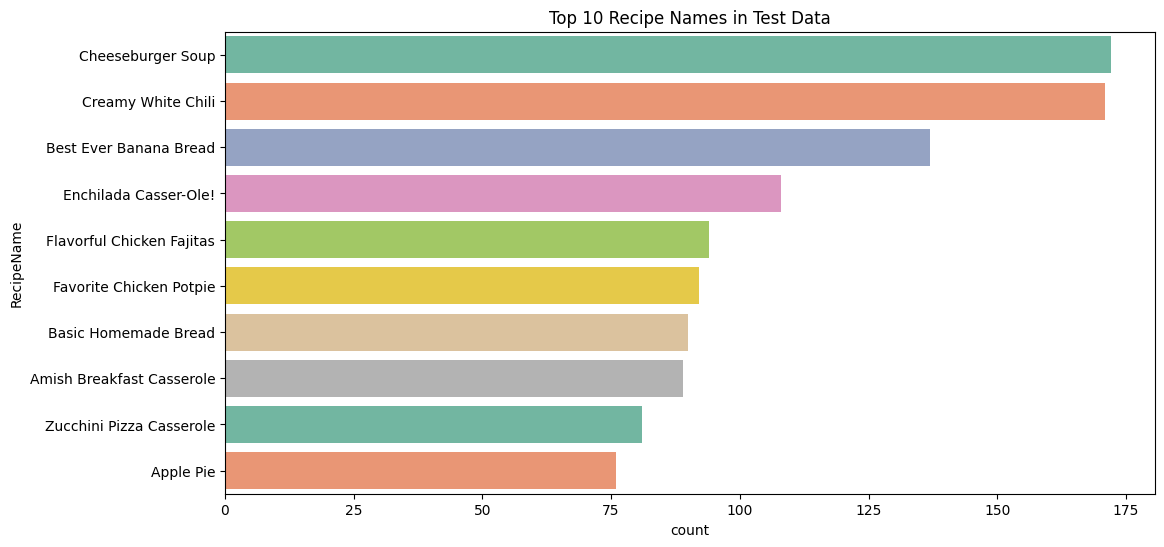

In [15]:

plt.figure(figsize=(12, 6))
sns.countplot(y='RecipeName', data=train_df, order=train_df['RecipeName'].value_counts().index[:10], palette='Set1')
plt.title('Top 10 Recipe Names in Training Data')
plt.show()

plt.figure(figsize=(12, 6))
sns.countplot(y='RecipeName', data=test_df, order=test_df['RecipeName'].value_counts().index[:10], palette='Set2')
plt.title('Top 10 Recipe Names in Test Data')
plt.show()


# EDA

## 1. Visualizing  the Target Variable


In [16]:
train_df['Rating'].value_counts()

Rating
5    10371
0     1272
4     1241
3      368
1      210
2      174
Name: count, dtype: int64

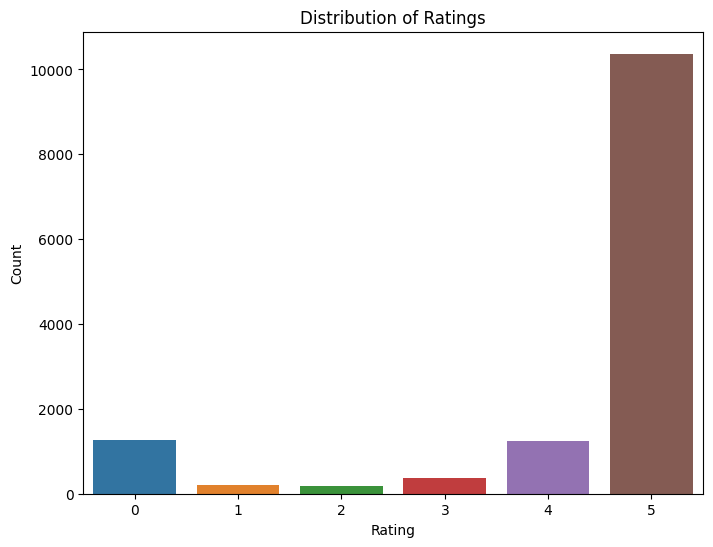

In [17]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Rating', data=train_df)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

#### * Heavily skewed, majority ratings are of 5. Users likely to give high rating if they are satisfied.
#### * The Rating column ranges from 0 to 5. The ratings should be considered from 1 to 5 ,however, a 0 rating tells the user did not rate the recipe.


## 2. Visualizing Relationships

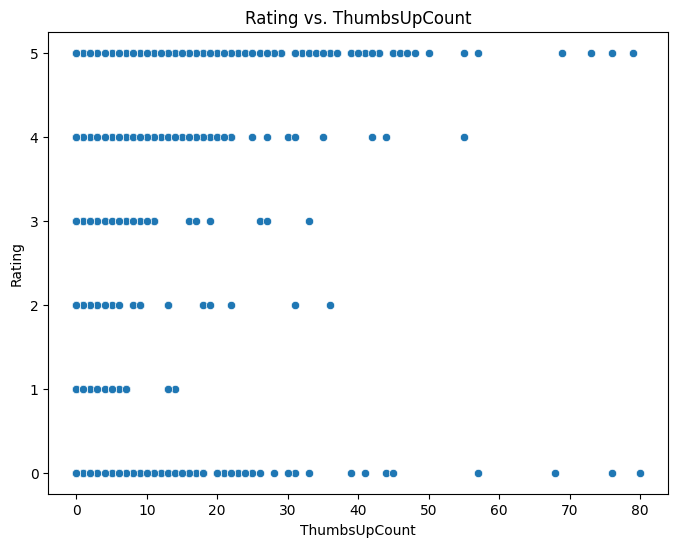

In [18]:
# Scatter plot of Rating vs. ThumbsUpCount
plt.figure(figsize=(8, 6))
sns.scatterplot(x='ThumbsUpCount', y='Rating', data=train_df)
plt.title('Rating vs. ThumbsUpCount')
plt.xlabel('ThumbsUpCount')
plt.ylabel('Rating')
plt.show()

#### * There appears to be a slight positive correlation between the number of thumbs up and the rating. 
#### * Most of the data points are concentrated in the lower range of ThumbsUpCount. 

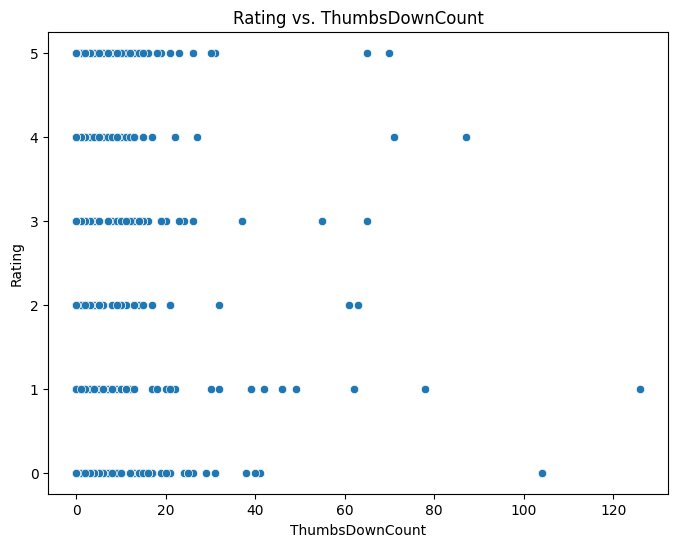

In [19]:
# Scatter plot of Rating vs. ThumbsDownCount
plt.figure(figsize=(8, 6))
sns.scatterplot(x='ThumbsDownCount', y='Rating', data=train_df)
plt.title('Rating vs. ThumbsDownCount')
plt.xlabel('ThumbsDownCount')
plt.ylabel('Rating')
plt.show()

#### * Very few recipes have a high number of thumbs down, and these are spread across different rating levels.
#### * Most of the data points are concentrated in the lower range of ThumbsDownCount. 

## 3.  Correlation Heatmap of Numerical Columns


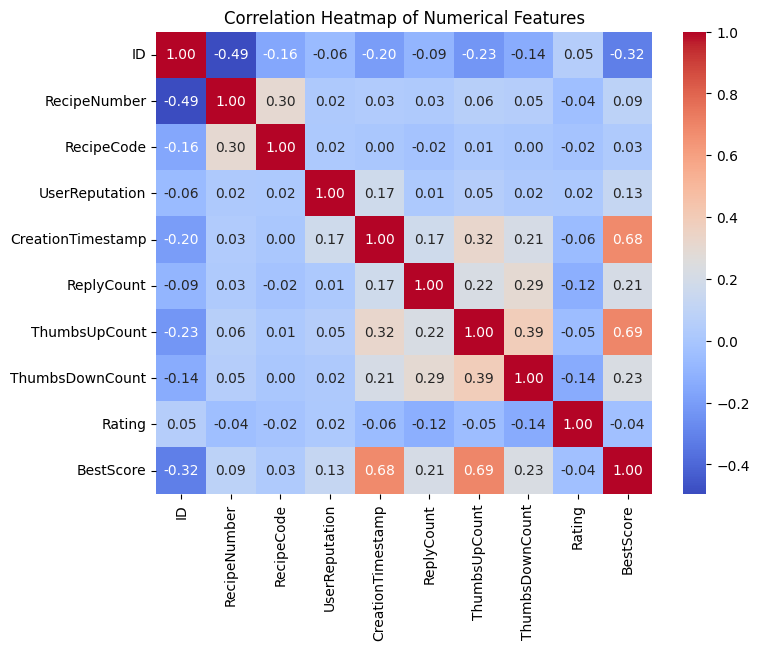

In [20]:
numeric_columns = train_df.select_dtypes(include=np.number).columns.tolist()
corr = train_df[numeric_columns].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Numerical Features')
plt.show()

#### 1. A strong positive correlation (0.68) between BestScore and CreationTimestamp.
#### 2. There is a positive correlation (0.69) between ThumbsUpCount and BestScore. ThumbsUpCount also has a moderate correlation with CreationTimestamp (0.32).
#### 3. ThumbsDownCount has a moderate positive correlation with BestScore (0.23). It also has a smaller correlation with CreationTimestamp (0.21).
#### 4. Rating does not show a strong correlation with any other features, with all correlations being very weak.
#### 5. RecipeNumber has no significant correlation with Rating, indicating it might not be predictive of the rating outcome.

## 4. Visualizing the most common words

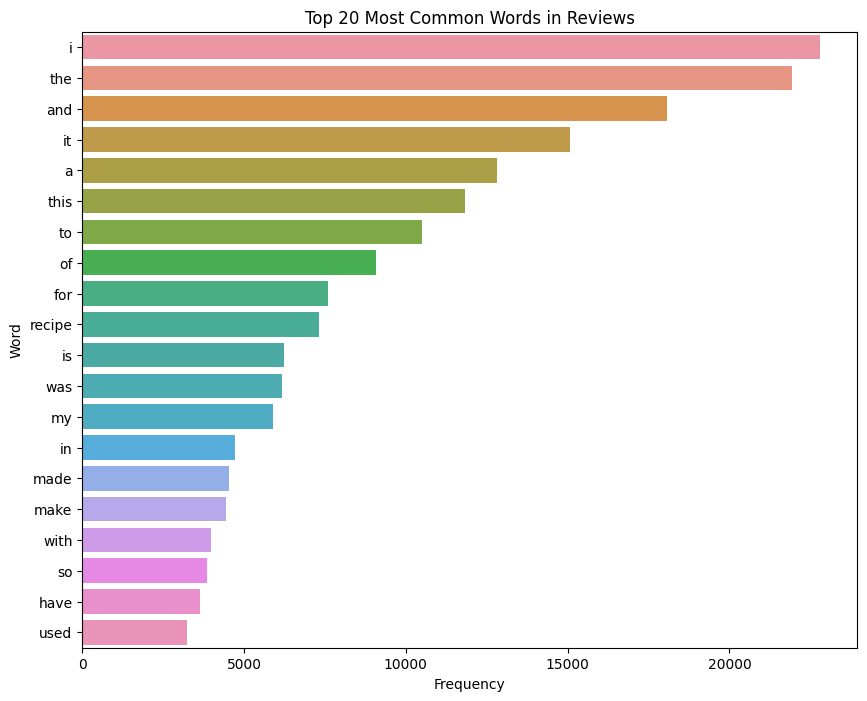

In [21]:
reviews_combined = ' '.join(train_df['Recipe_Review'].dropna()).lower() # combines in a single string, removes the space and does lowercase
reviews_combined = re.sub(r'[^a-z\s]', '', reviews_combined) # removing anything that's not a letter or space
words = reviews_combined.split()

word_counts = Counter(words)
most_common_words = word_counts.most_common(20)

words_df = pd.DataFrame(most_common_words, columns=['Word', 'Frequency'])
plt.figure(figsize=(10, 8))
sns.barplot(x='Frequency', y='Word', data=words_df)
plt.title('Top 20 Most Common Words in Reviews')
plt.show()

## 5. Outlier Detection

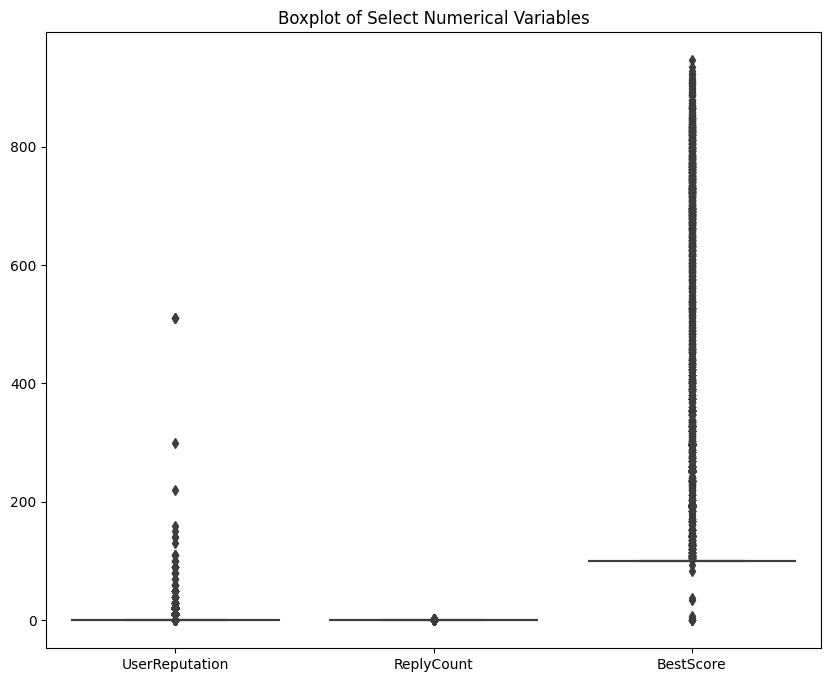

In [22]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=train_df[['UserReputation', 'ReplyCount', 'BestScore']])
plt.title('Boxplot of Select Numerical Variables')
plt.show()

#### 1. UserReputation has a small IQR, close to zero, indicating that most of the data points fall near the lower end of the scale. There are some outliers.
#### 2. For ReplyCount, the median is very close to zero, and IQR is close to the bottom as well, which tells most recipes have few or 0 replies. There are some outliers.
#### 3. Large number of outliers and the whsiker extends high, which tells many recipes have higher scores than rest.

## 6. More pairwise relationships

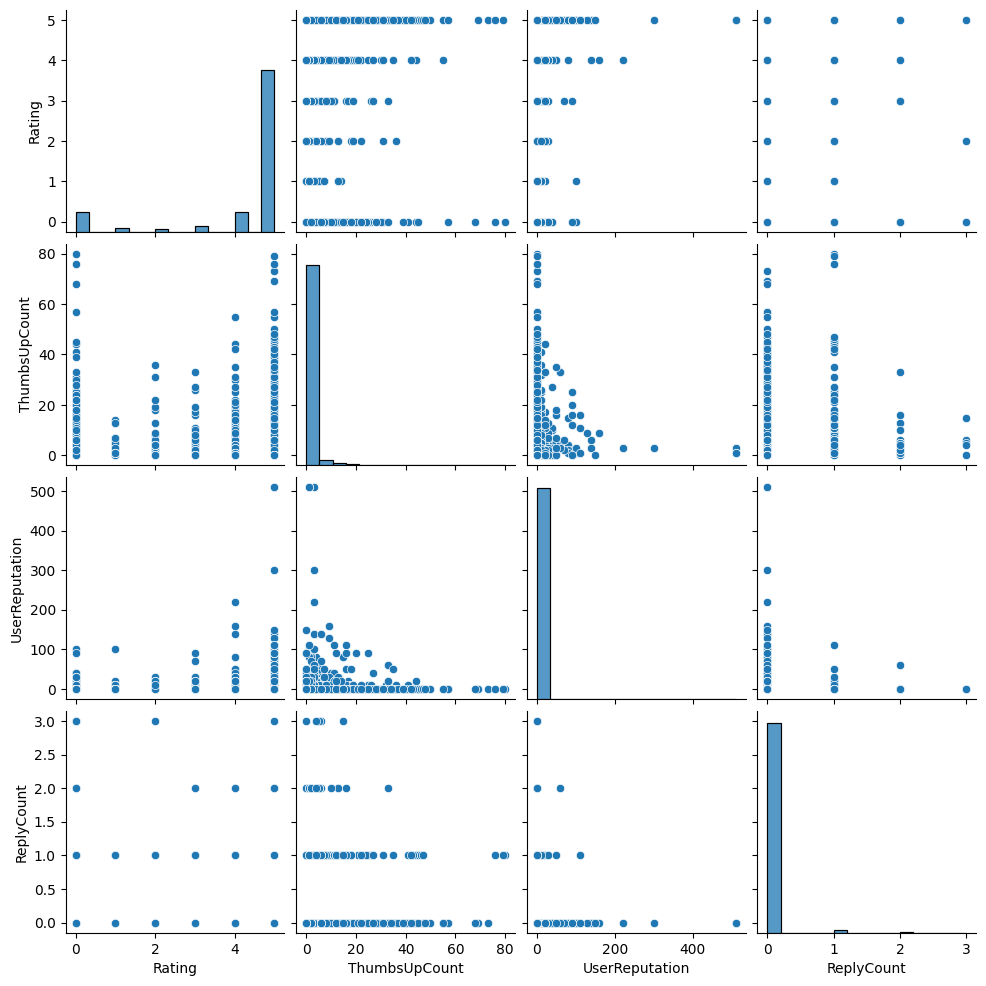

In [23]:
sns.pairplot(train_df[['Rating', 'ThumbsUpCount', 'UserReputation', 'ReplyCount']], diag_kind='auto')
plt.show()

# Data Cleaning and Preprocessing

## Filling the missing values

In [24]:
train_df.isnull().sum()

ID                   0
RecipeNumber         0
RecipeCode           0
RecipeName           0
CommentID            0
UserID               0
UserName             0
UserReputation       0
CreationTimestamp    0
ReplyCount           0
ThumbsUpCount        0
ThumbsDownCount      0
Rating               0
BestScore            0
Recipe_Review        2
dtype: int64

In [25]:
train_df['Recipe_Review'].fillna('No review', inplace=True)


#### * As the Recipe_Review columns had two missing values, they were filled with 'No review'.

# Feature Engineering

## Working around CreationTimestamp column

In [26]:
train_df['CreationTimestamp'].head()

0    1622717078
1    1622717852
2    1622717357
3    1622648899
4    1622718260
Name: CreationTimestamp, dtype: int64

In [27]:

train_df['CreationTimestamp'] = pd.to_datetime(train_df['CreationTimestamp'], unit='s')
train_df['Year'] = train_df['CreationTimestamp'].dt.year
train_df['Month'] = train_df['CreationTimestamp'].dt.month
train_df['Day'] = train_df['CreationTimestamp'].dt.day
train_df['Hour'] = train_df['CreationTimestamp'].dt.hour
train_df['DayOfWeek'] = train_df['CreationTimestamp'].dt.dayofweek

def get_part_of_day(hour):
    if (hour >= 0) and (hour < 6):
        return 'night'
    elif (hour >= 6) and (hour < 12):
        return 'morning'
    elif (hour >= 12) and (hour < 18):
        return 'afternoon'
    else:
        return 'evening'

train_df['PartOfDay'] = train_df['Hour'].apply(get_part_of_day)

#### CreationTimestamp column was the one where it was presumed a meaningful result could be extracted. 
#### The feature was converted into a DateTime format and several components were extracted. 

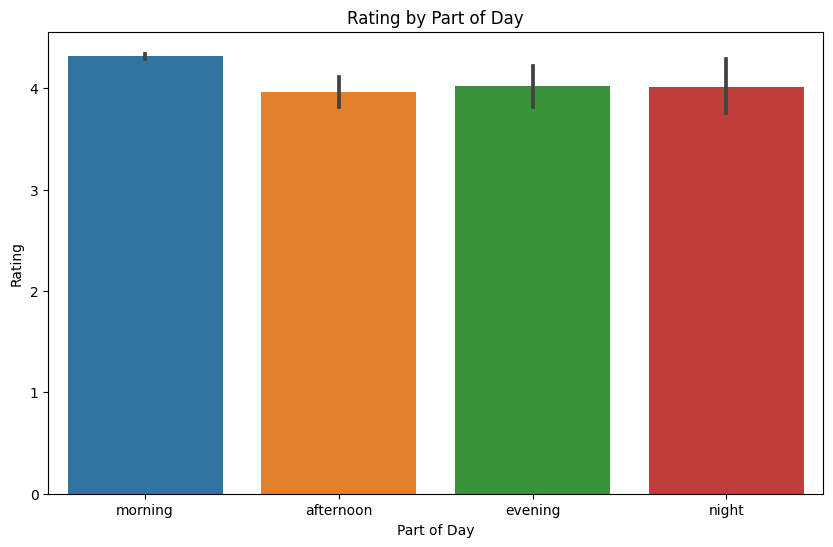

In [28]:
plt.figure(figsize=(10, 6))
sns.barplot(x='PartOfDay', y='Rating', data=train_df)
plt.title('Rating by Part of Day')
plt.xlabel('Part of Day')
plt.ylabel('Rating')
plt.show()

#### * Majority of the user give a rating in the morning.

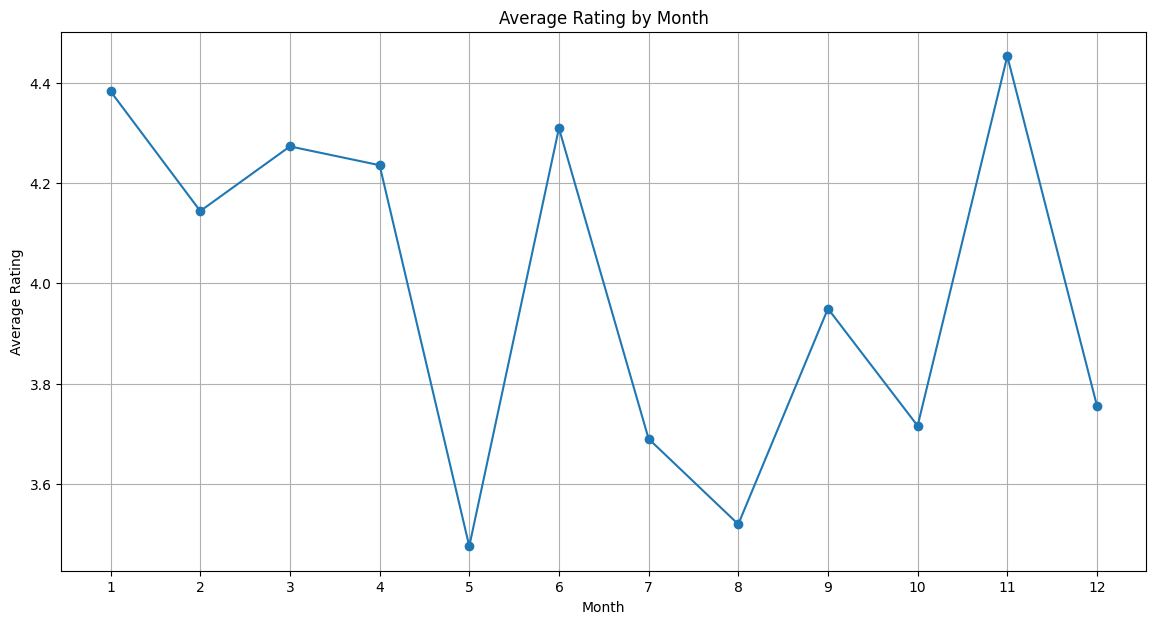

In [29]:
plt.figure(figsize=(14, 7))
train_df.groupby('Month')['Rating'].mean().plot(kind='line', marker='o')
plt.title('Average Rating by Month')
plt.xlabel('Month')
plt.ylabel('Average Rating')
plt.xticks(range(1, 13)) 
plt.grid(True)
plt.show()


#### * Fluctuations over different months indicate seasonal trends or some external influence or a change in database.

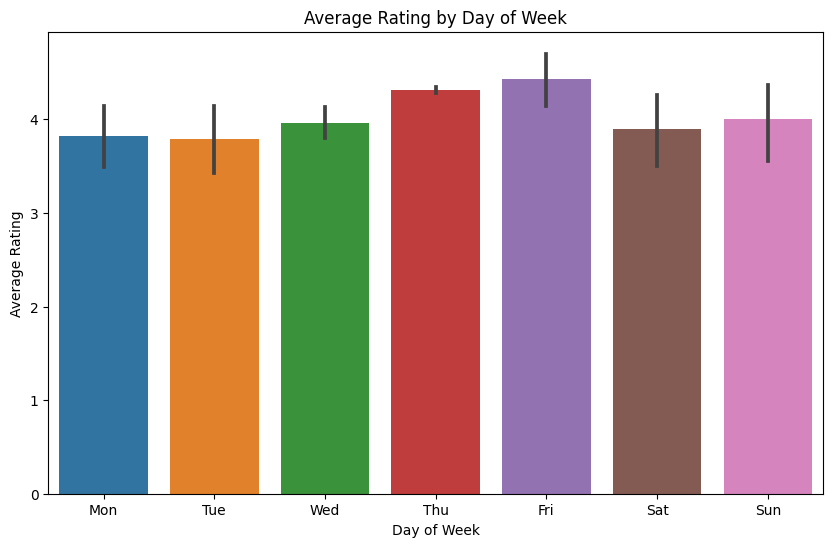

In [30]:
plt.figure(figsize=(10, 6))
sns.barplot(x='DayOfWeek', y='Rating', data=train_df)
plt.title('Average Rating by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Rating')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.show()


#### * Average rating for each day is similar. Friday has the highest peak. It could be due to start of the weekend.

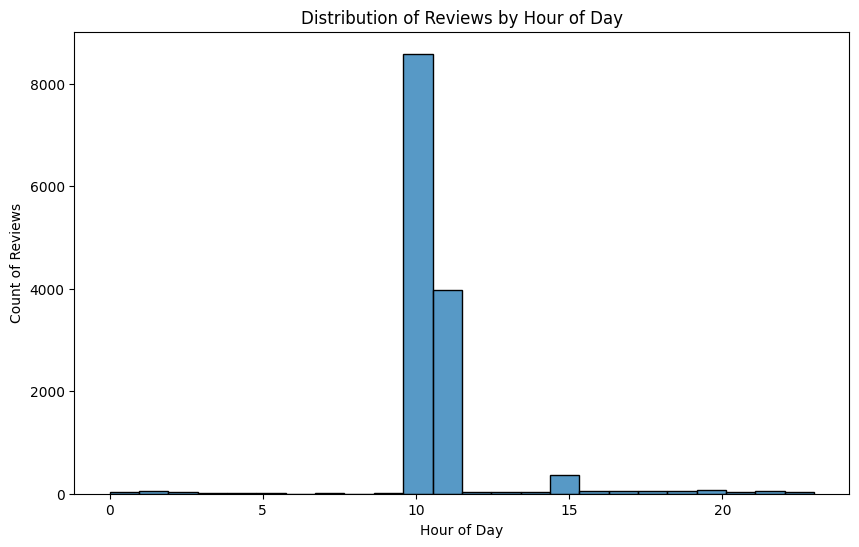

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(train_df['Hour'], bins=24)
plt.title('Distribution of Reviews by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Count of Reviews')
plt.show()



#### * The peaks and the concentration being observed at 10th to 11th hour indicates most users are active around this time to give a review.

In [32]:
train_df = train_df.drop(columns=[ 'CreationTimestamp', 'RecipeNumber', 'RecipeCode', 'CommentID', 'UserID', 'UserName'])

#### 1. As the relevant features were extracted from CreationTimestamp, it is now dropped.
#### 2. RecipeNumber, RecipeCode and CommentID are unique to each and could not be useful in predictive analysis.
#### 3. Similar for UserID and UserName.  

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13636 entries, 0 to 13635
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               13636 non-null  int64 
 1   RecipeName       13636 non-null  object
 2   UserReputation   13636 non-null  int64 
 3   ReplyCount       13636 non-null  int64 
 4   ThumbsUpCount    13636 non-null  int64 
 5   ThumbsDownCount  13636 non-null  int64 
 6   Rating           13636 non-null  int64 
 7   BestScore        13636 non-null  int64 
 8   Recipe_Review    13636 non-null  object
 9   Year             13636 non-null  int32 
 10  Month            13636 non-null  int32 
 11  Day              13636 non-null  int32 
 12  Hour             13636 non-null  int32 
 13  DayOfWeek        13636 non-null  int32 
 14  PartOfDay        13636 non-null  object
dtypes: int32(5), int64(7), object(3)
memory usage: 1.3+ MB


## Scaling & Encoding the train data 

In [34]:
# Defining preprocessor for numerical and categorical features
num_preprocessor = Pipeline([
    ('scaler', MinMaxScaler())
])

cat_preprocessor = Pipeline([
    ('encoder', OneHotEncoder())
])

# Combining preprocessors
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_preprocessor, ['UserReputation', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'BestScore', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek']),
        ('cat', cat_preprocessor, ['RecipeName', 'PartOfDay'])
    ],
    remainder='passthrough'
)

#### * MinMaxScaler and OneHotEncoder are being used on numerical and categorical columns respectively.
#### * Column Transformer is used to combine the preprocessors on the respective columns.

In [35]:
# Defining TF-IDF vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, encoding='utf-8', decode_error='ignore', stop_words='english', lowercase=True, token_pattern='(?u)\\b\\w*[a-zA-Z]\\w*\\b')

#### * TfidfVectorizer is a feature extraction method which is used to transform the text into numerical format. 

In [36]:
# Splitting the data
X = train_df.drop('Rating', axis =1)
y = train_df['Rating']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

In [37]:
# Fitting and transforming the training data with TF-IDF vectorizer and preprocessor
X_train_tf = tfidf.fit_transform(X_train['Recipe_Review'])
X_train_other = preprocessor.fit_transform(X_train.drop(columns=['Recipe_Review']))
X_train_proc = hstack([X_train_tf, X_train_other])

In [38]:
# Transforming the validation data with the fitted TF-IDF vectorizer and preprocessor
X_val_tf = tfidf.transform(X_val['Recipe_Review'])
X_val_other = preprocessor.transform(X_val.drop(columns=['Recipe_Review']))
X_val_proc = hstack([X_val_tf, X_val_other])

In [39]:
X_train_proc.shape


(9545, 8606)

In [40]:
X_val_proc.shape

(4091, 8606)

### Feature Selection

In [41]:
selector = SelectKBest(chi2, k=2000)
X_train_reduced = selector.fit_transform(X_train_proc, y_train)
X_val_reduced = selector.transform(X_val_proc)

#### *SelectKBest is used with chi-squared test. It is used to select features and prevent overfitting.

## Preprocessing the test data

In [42]:
test_df['CreationTimestamp'] = pd.to_datetime(test_df['CreationTimestamp'], unit='s')
test_df['Year'] = test_df['CreationTimestamp'].dt.year
test_df['Month'] = test_df['CreationTimestamp'].dt.month
test_df['Day'] = test_df['CreationTimestamp'].dt.day
test_df['Hour'] = test_df['CreationTimestamp'].dt.hour
test_df['DayOfWeek'] = test_df['CreationTimestamp'].dt.dayofweek
def get_part_of_day(hour):
    if (hour >= 0) and (hour < 6):
        return 'night'
    elif (hour >= 6) and (hour < 12):
        return 'morning'
    elif (hour >= 12) and (hour < 18):
        return 'afternoon'
    else:
        return 'evening'

test_df['PartOfDay'] = test_df['Hour'].apply(get_part_of_day)

In [43]:
test_df = test_df.drop(columns=['CreationTimestamp', 'RecipeNumber', 'RecipeCode', 'CommentID', 'UserID', 'UserName'])

In [44]:
# Fitting and transforming the test data with TF-IDF vectorizer and preprocessor
X_test_tf = tfidf.transform(test_df['Recipe_Review'])
X_test_other = preprocessor.transform(test_df.drop(columns=['Recipe_Review']))
X_test_proc = hstack([X_test_tf, X_test_other])


In [45]:
X_test_proc.shape

(4546, 8606)

In [46]:
X_test_reduced = selector.transform(X_test_proc)

# Model Building

## 1. Logistic Regression

In [47]:
#Logistic Regression
param_grid_lr = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'class_weight': ['balanced'],
    'max_iter': [200]
}

In [48]:

lr = LogisticRegression()
random_search_lr = RandomizedSearchCV(estimator=lr, param_distributions=param_grid_lr, cv=3, n_jobs=-1, verbose=2)
random_search_lr.fit(X_train_reduced, y_train)
print(random_search_lr.best_params_)



Fitting 3 folds for each of 10 candidates, totalling 30 fits


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

{'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 200, 'class_weight': 'balanced', 'C': 1}


In [49]:
best_lr = random_search_lr.best_estimator_
best_lr.fit(X_train_reduced, y_train)
val_predictions_lr = best_lr.predict(X_val_reduced)



In [50]:
print("Accuracy (Logistic Regression):", accuracy_score(y_val, val_predictions_lr))

Accuracy (Logistic Regression): 0.7352725494989


### Logistic Regression model with its highest accuracy of 0.7594 is below.

In [51]:
'''#Logistic Regression
param_grid_lr = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'class_weight': ['balanced', None],
    'max_iter': [2000,4000]
}
lr = LogisticRegression()
grid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=3, n_jobs=-1, verbose=2)
grid_search_lr.fit(X_train_reduced, y_train)
print(grid_search_lr.best_params_)
best_lr = grid_search_lr.best_estimator_
best_lr.fit(X_train_reduced, y_train)
val_predictions_lr = best_lr.predict(X_val_reduced)
print("Accuracy (Logistic Regression):", accuracy_score(y_val, val_predictions_lr))
Accuracy (Logistic Regression): 0.7594720117330725
'''

'#Logistic Regression\nparam_grid_lr = {\n    \'C\': [0.001, 0.01, 0.1, 1, 10, 100],\n    \'penalty\': [\'l1\', \'l2\', \'elasticnet\'],\n    \'solver\': [\'newton-cg\', \'lbfgs\', \'liblinear\', \'sag\', \'saga\'],\n    \'class_weight\': [\'balanced\', None],\n    \'max_iter\': [2000,4000]\n}\nlr = LogisticRegression()\ngrid_search_lr = GridSearchCV(estimator=lr, param_grid=param_grid_lr, cv=3, n_jobs=-1, verbose=2)\ngrid_search_lr.fit(X_train_reduced, y_train)\nprint(grid_search_lr.best_params_)\nbest_lr = grid_search_lr.best_estimator_\nbest_lr.fit(X_train_reduced, y_train)\nval_predictions_lr = best_lr.predict(X_val_reduced)\nprint("Accuracy (Logistic Regression):", accuracy_score(y_val, val_predictions_lr))\nAccuracy (Logistic Regression): 0.7594720117330725\n'

## 2. LightGBM

In [52]:
# LightGBM Model
param_grid_lgbm = {
    'n_estimators' : [360],
    'num_leaves': [25],
    'reg_alpha': [0.60],
    'reg_lambda' : [0.06],
    'min_child_samples': [5],
    'learning_rate': [0.09],
    'max_depth': [20],
    'subsample': [0.13], 
    'colsample_bytree': [0.85]
}

In [53]:
lgbm = LGBMClassifier()
random_search_lgbm = RandomizedSearchCV(estimator=lgbm, param_distributions=param_grid_lgbm, n_iter=100, cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search_lgbm.fit(X_train_reduced, y_train)
print(random_search_lgbm.best_params_)

best_lgbm = random_search_lgbm.best_estimator_
best_lgbm.fit(X_train_reduced, y_train)

val_predictions_lgbm = best_lgbm.predict(X_val_reduced)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'subsample': 0.13, 'reg_lambda': 0.06, 'reg_alpha': 0.6, 'num_leaves': 25, 'n_estimators': 360, 'min_child_samples': 5, 'max_depth': 20, 'learning_rate': 0.09, 'colsample_bytree': 0.85}


In [54]:
print("Accuracy (LightGBM):", accuracy_score(y_val, val_predictions_lgbm))

Accuracy (LightGBM): 0.7672940601319971


## The params which gave the highest accuracy for LightGBM model and overall, accuracy of 0.768 is below.
### This is the best model with an accuracy of 0.768.

In [55]:
'''# LightGBM Model
param_grid_lgbm = {
    'n_estimators' : [360,400],
    'num_leaves': [25,31],
    'reg_alpha': [0.60,0.75],
    'reg_lambda' : [0.06,0.09],
    'min_child_samples': [5,7],
    'learning_rate': [0.09,1.12],
    'max_depth': [20, 30],
    'subsample': [0.13,0.15], 
    'colsample_bytree': [0.85,0.95]
}
lgbm = LGBMClassifier()
random_search_lgbm = RandomizedSearchCV(estimator=lgbm, param_distributions=param_grid_lgbm, n_iter=100, cv=3, n_jobs=-1, verbose=2, random_state=42)
random_search_lgbm.fit(X_train_reduced, y_train)
print(random_search_lgbm.best_params_)

best_lgbm = random_search_lgbm.best_estimator_
best_lgbm.fit(X_train_reduced, y_train)

val_predictions_lgbm = best_lgbm.predict(X_val_reduced)
print("Accuracy (LightGBM):", accuracy_score(y_val, val_predictions_lgbm))
Accuracy (LightGBM): 0.76798541656869
'''

'# LightGBM Model\nparam_grid_lgbm = {\n    \'n_estimators\' : [360,400],\n    \'num_leaves\': [25,31],\n    \'reg_alpha\': [0.60,0.75],\n    \'reg_lambda\' : [0.06,0.09],\n    \'min_child_samples\': [5,7],\n    \'learning_rate\': [0.09,1.12],\n    \'max_depth\': [20, 30],\n    \'subsample\': [0.13,0.15], \n    \'colsample_bytree\': [0.85,0.95]\n}\nlgbm = LGBMClassifier()\nrandom_search_lgbm = RandomizedSearchCV(estimator=lgbm, param_distributions=param_grid_lgbm, n_iter=100, cv=3, n_jobs=-1, verbose=2, random_state=42)\nrandom_search_lgbm.fit(X_train_reduced, y_train)\nprint(random_search_lgbm.best_params_)\n\nbest_lgbm = random_search_lgbm.best_estimator_\nbest_lgbm.fit(X_train_reduced, y_train)\n\nval_predictions_lgbm = best_lgbm.predict(X_val_reduced)\nprint("Accuracy (LightGBM):", accuracy_score(y_val, val_predictions_lgbm))\nAccuracy (LightGBM): 0.76798541656869\n'

## 3. RandomForestClassifier

In [56]:
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1,4],
    'bootstrap': [True, False]
}

In [57]:
rf = RandomForestClassifier()

random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_grid_rf, cv=2, n_jobs=-1, verbose=2)

random_search_rf.fit(X_train_reduced, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END bootstrap=True, max_depth=10, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   1.4s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   4.5s
[CV] END bootstrap=False, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   4.2s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   2.9s
[CV] END bootstrap=True, max_depth=30, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   2.9s
[

RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30],
                                        'min_samples_leaf': [1, 4],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [100, 200]},
                   verbose=2)

In [58]:
best_rf = random_search_rf.best_estimator_

best_rf.fit(X_train_reduced, y_train)

val_predictions_rf = best_rf.predict(X_val_reduced)

In [59]:
print("Accuracy (RandomForst):", accuracy_score(y_val, val_predictions_rf))

Accuracy (RandomForst): 0.7509166462967489


### The RandomForestClassifier model which gave its highest accuracy of 0.7611 is below.

In [60]:
'''param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rf = RandomForestClassifier()

grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

grid_search_rf.fit(X_train_reduced, y_train)

best_rf = grid_search_rf.best_estimator_

best_rf.fit(X_train_reduced, y_train)

val_predictions_rf = best_rf.predict(X_val_reduced)
val_predictions = best_rf.predict(X_val_reduced)
print("Accuracy (Random Forest):", accuracy_score(y_val, val_predictions_rf))
Accuracy (Random Forest): 0.7611830848203374'''

'param_grid = {\n    \'n_estimators\': [100, 200, 300],\n    \'max_depth\': [None, 10, 20, 30, 40, 50],\n    \'min_samples_split\': [2, 5, 10],\n    \'min_samples_leaf\': [1, 2, 4],\n    \'bootstrap\': [True, False]\n}\nrf = RandomForestClassifier()\n\ngrid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)\n\ngrid_search_rf.fit(X_train_reduced, y_train)\n\nbest_rf = grid_search_rf.best_estimator_\n\nbest_rf.fit(X_train_reduced, y_train)\n\nval_predictions_rf = best_rf.predict(X_val_reduced)\nval_predictions = best_rf.predict(X_val_reduced)\nprint("Accuracy (Random Forest):", accuracy_score(y_val, val_predictions_rf))\nAccuracy (Random Forest): 0.7611830848203374'

## 4. XGBoost

In [61]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5],
    'gamma': [0, 0.25, 0.5]
}

In [62]:
xgb_model = xgb.XGBClassifier()

random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid_xgb, cv=3, n_jobs=-1, verbose=2)

random_search_xgb.fit(X_train_reduced, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=100; total time=   5.4s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=100; total time=   5.3s
[CV] END gamma=0.5, learning_rate=0.1, max_depth=3, n_estimators=100; total time=   5.8s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100; total time=   5.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100; total time=   5.3s
[CV] END gamma=0, learning_rate=0.1, max_depth=3, n_estimators=100; total time=   5.4s
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, n_estimators=200; total time=  11.9s
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, n_estimators=200; total time=  12.6s
[CV] END gamma=0.25, learning_rate=0.01, max_depth=3, n_estimators=200; total time=  11.7s
[CV] END gamma=0, learning_rate=0.1, max_depth=5, n_estimators=100; total time=  12.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=5, n

RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, feature_types=None,
                                           gamma=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate...
                                           max_cat_to_onehot=None,
                                           max_delta_step=None, max_depth=None,
                                           max_leaves=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None,
                                           random_state=None, ...),
                   n_jobs=-1,
                   param_distributions={'gamma': [0, 0.25, 0.5],
                                        'learning_rate': [0.01, 0.1],
                                        'max_depth': [3, 5],
                                        'n_estimators': [100, 200]},
                   verbose=2)

In [63]:
best_xgb = random_search_xgb.best_estimator_

best_xgb.fit(X_train_reduced, y_train)

val_predictions_xgb = best_xgb.predict(X_val_reduced)

In [64]:
print("Accuracy (XGB):", accuracy_score(y_val, val_predictions_xgb))

Accuracy (XGB): 0.7606942067954046


### The XGBClassifier model which gave its highest accuracy of 0.7646 is below.

In [65]:
'''param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.25, 0.5]
}
xgb_model = xgb.XGBClassifier()

random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid_xgb, n_iter=50, cv=3, n_jobs=-1, verbose=2)
random_search_xgb.fit(X_train_reduced, y_train)

best_xgb = random_search_xgb.best_estimator_

best_xgb.fit(X_train_reduced, y_train)

val_predictions_xgb = best_xgb.predict(X_val_reduced)

accuracy = accuracy_score(y_val, val_predictions_xgb)
print("Accuracy (XGB):", accuracy_score(y_val, val_predictions_xgb))
Accuracy (XGB): 0.7626854573169'''

'param_grid_xgb = {\n    \'n_estimators\': [100, 200, 300],\n    \'learning_rate\': [0.01, 0.1, 0.2],\n    \'max_depth\': [3, 5, 7],\n    \'gamma\': [0, 0.25, 0.5]\n}\nxgb_model = xgb.XGBClassifier()\n\nrandom_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid_xgb, n_iter=50, cv=3, n_jobs=-1, verbose=2)\nrandom_search_xgb.fit(X_train_reduced, y_train)\n\nbest_xgb = random_search_xgb.best_estimator_\n\nbest_xgb.fit(X_train_reduced, y_train)\n\nval_predictions_xgb = best_xgb.predict(X_val_reduced)\n\naccuracy = accuracy_score(y_val, val_predictions_xgb)\nprint("Accuracy (XGB):", accuracy_score(y_val, val_predictions_xgb))\nAccuracy (XGB): 0.7626854573169'

## Test Predictions for each model:

In [66]:
# LogReg test predictions
test_predictions_lr = best_lr.predict(X_test_reduced)


In [67]:
# RandomForest test predictions
test_predictions_rf = best_rf.predict(X_test_reduced)

In [68]:
#XGBoost test predictions
test_predictions_xgb = best_xgb.predict(X_test_reduced)

In [69]:
#LightBGM test predictions
test_predictions_lgbm = best_lgbm.predict(X_test_reduced)

## Comparison of built models

In [70]:
models = [best_lr, best_rf, best_xgb, best_lgbm]
model_names = ['Logistic Regression', 'Random Forest', 'XGBoost', 'LightGBM']

performance_data = []

for i, model in enumerate(models):
    predictions = model.predict(X_val_reduced)
    performance_data.append({
        'Model': model_names[i],
        'Accuracy': accuracy_score(y_val, predictions),
        'Precision': precision_score(y_val, predictions, average='weighted'),
        'Recall': recall_score(y_val, predictions, average='weighted'),
        'F1 Score': f1_score(y_val, predictions, average='weighted')
    })

performance_df = pd.DataFrame(performance_data)

performance_df.set_index('Model', inplace=True)

print(performance_df)

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                     Accuracy  Precision    Recall  F1 Score
Model                                                       
Logistic Regression  0.735273   0.711931  0.735273  0.720863
Random Forest        0.750917   0.735732  0.750917  0.646750
XGBoost              0.760694   0.691098  0.760694  0.677594
LightGBM             0.767294   0.708089  0.767294  0.715946


Insights:
* LGBM with the highest accuracy of 0.7673.
* For precision, Logistic and LightGBM are the top performers.
* Logistic has the highest F1 score of 0.72.
* The models are generally good at making correct predictions, there's a significant portion of specific classes that are being misclassified. This is particularly evident in the Random Forest model, where there's a larger gap between accuracy and the other metrics.
***LGBM is found to be the best performing model for this dataset among all as it is giving the highest accuracy.**

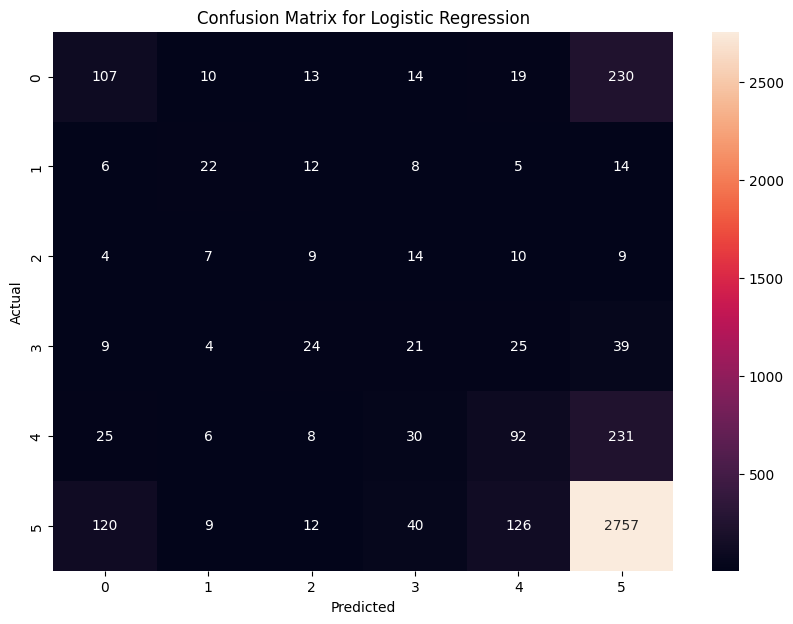

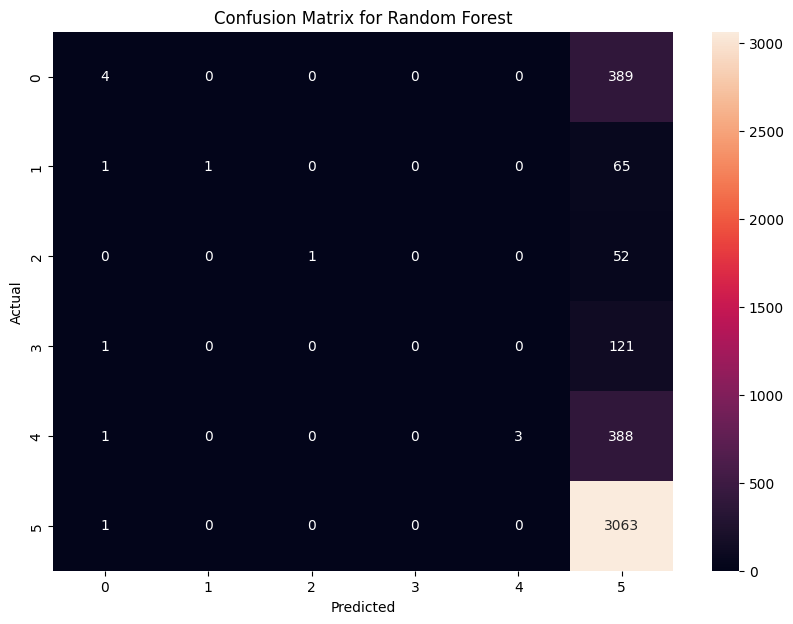

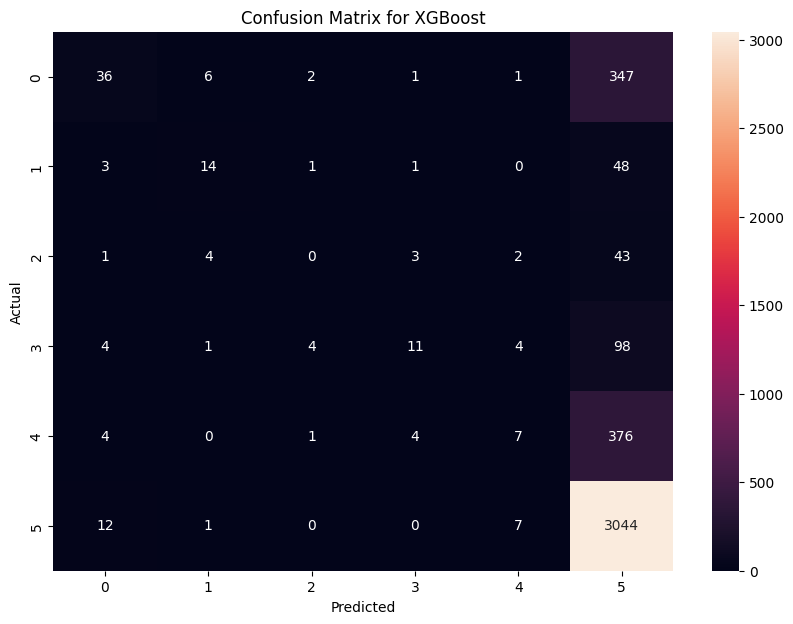

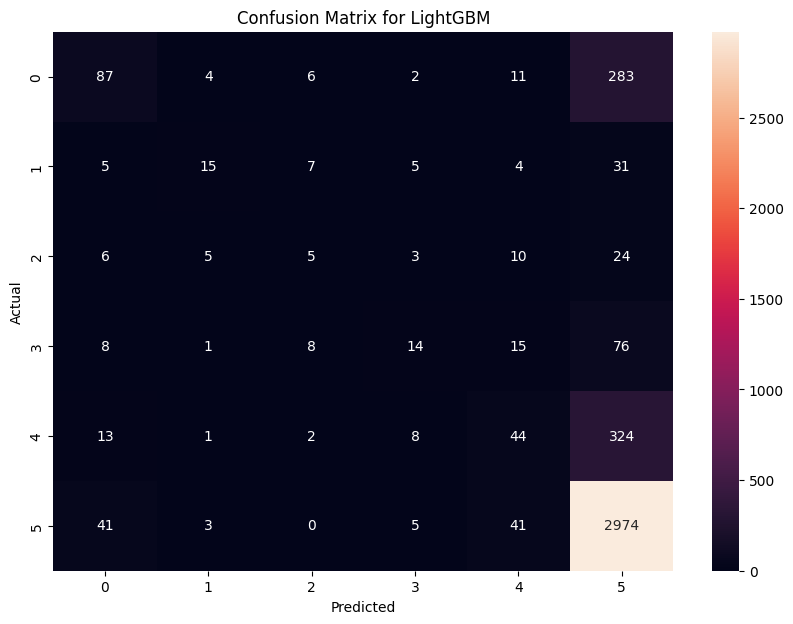

In [71]:
for i, model in enumerate(models):
    predictions = model.predict(X_val_reduced)
    cm = confusion_matrix(y_val, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g')
    plt.title(f'Confusion Matrix for {model_names[i]}')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()


## There is class imbalance issue as the majority class is immense as compared to minority class across all the models.
## All models show a preference for predicting the majority class (class 5), which may indicate an imbalanced dataset.

### To address this, SMORE is used but it did not increase accuracy.

In [72]:
'''preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), ['UserReputation', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'BestScore', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek']),
        ('cat', OneHotEncoder(), ['RecipeName', 'PartOfDay'])
    ],
    remainder='passthrough'
)

tfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, encoding='utf-8', decode_error='ignore', stop_words='english', lowercase=True, token_pattern='(?u)\\b\\w*[a-zA-Z]\\w*\\b')

# Initializing SMOTE
smote = SMOTE(random_state=42)

# Splitting the data
X_text = train_df['Recipe_Review'].fillna('No review')
X_other = train_df.drop(columns=['Rating', 'Recipe_Review'])
y = train_df['Rating']

# Combining the text and non-text features after vectorization and other transformations
X_combined = hstack([X_text, X_other])

# Splitting into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_combined, y, test_size=0.3, random_state=42)

pipeline = ImbPipeline(steps=[
    ('tfidf', tfidf_vectorizer),
    ('preprocessor', preprocessor),
    ('smote', smote)
])

pipeline.fit(X_train, y_train)'''



"preprocessor = ColumnTransformer(\n    transformers=[\n        ('num', MinMaxScaler(), ['UserReputation', 'ReplyCount', 'ThumbsUpCount', 'ThumbsDownCount', 'BestScore', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek']),\n        ('cat', OneHotEncoder(), ['RecipeName', 'PartOfDay'])\n    ],\n    remainder='passthrough'\n)\n\ntfidf_vectorizer = TfidfVectorizer(sublinear_tf=True, encoding='utf-8', decode_error='ignore', stop_words='english', lowercase=True, token_pattern='(?u)\\b\\w*[a-zA-Z]\\w*\\b')\n\n# Initializing SMOTE\nsmote = SMOTE(random_state=42)\n\n# Splitting the data\nX_text = train_df['Recipe_Review'].fillna('No review')\nX_other = train_df.drop(columns=['Rating', 'Recipe_Review'])\ny = train_df['Rating']\n\n# Combining the text and non-text features after vectorization and other transformations\nX_combined = hstack([X_text, X_other])\n\n# Splitting into training and validation sets\nX_train, X_val, y_train, y_val = train_test_split(X_combined, y, test_size=0.3, random_state=42)

In [73]:
'''for model in models:
    model.fit(X_train_reduced, y_train)
    predictions = model.predict(X_val_reduced)

    report = classification_report(y_val, predictions, output_dict=True)
    df = pd.DataFrame(report).transpose()
    df = df.sort_values(by=['f1-score'], ascending=False)

    plt.figure(figsize=(10, 10))
    sns.heatmap(df, annot=True, fmt=".2f", cmap='Reds')
    plt.title(f"Classification Report for {type(model).__name__}")
    plt.show()
'''


'for model in models:\n    model.fit(X_train_reduced, y_train)\n    predictions = model.predict(X_val_reduced)\n\n    report = classification_report(y_val, predictions, output_dict=True)\n    df = pd.DataFrame(report).transpose()\n    df = df.sort_values(by=[\'f1-score\'], ascending=False)\n\n    plt.figure(figsize=(10, 10))\n    sns.heatmap(df, annot=True, fmt=".2f", cmap=\'Reds\')\n    plt.title(f"Classification Report for {type(model).__name__}")\n    plt.show()\n'

In [74]:
'''submission= pd.DataFrame({"ID": range(1,4547),
                         "total_amount": test_predictions_lgbm})

submission.to_csv('submission.csv', index=False)'''

'submission= pd.DataFrame({"ID": range(1,4547),\n                         "total_amount": test_predictions_lgbm})\n\nsubmission.to_csv(\'submission.csv\', index=False)'